# Multi-Layer Perceptron

This is a partial implementation of "A Neural Probabilistic Language Model" (Bengio et al., 2003). The main resource for this was the Andrej Karpathy's makemore video: https://www.youtube.com/watch?v=TCH_1BHY58I. The dataset is a list of names, stored in a file called names.txt

The original video uses pytorch, but I wanted to try out tinygrad so I ported it over. The optimizer is a simple SGD, so I don't explicitly write it out and instead just use the SGD implementation from tinygrad.


In [1]:
from tinygrad.tensor import Tensor
import matplotlib.pyplot as plt

%matplotlib inline

DEVICE="METAL"

## Load and build dataset

In [2]:
with open("names.txt", "r") as f:
    words = f.read().splitlines()

# build vocabulary of characters from/to integers
chars = sorted(set("".join(words)))
stoi = {ch: i+1 for i, ch in enumerate(chars)} # string to int
# we also want to add a terminal character
stoi["."] = 0
itos = {i: ch for ch, i in stoi.items()} # int to string

print("Vocabulary size:", len(stoi))

# build dataset
context_length = 4

X = []
Y = []

for word in words:
    context = [0]*context_length
    for character in word + ".":
        goal = stoi[character]
        X.append(context)
        Y.append(goal)
        context = context[1:] + [goal]

X = Tensor(X, device=DEVICE)
Y = Tensor(Y, device=DEVICE)

X.shape, X.dtype, Y.shape, Y.dtype

Vocabulary size: 27


((228146, 4), dtypes.float, (228146,), dtypes.float)

## Define Network

In [3]:
# define the mapping matrix C, 
# and the respective layers
neurons = 100
embedding_size = 4

C = Tensor.randn(27, embedding_size, device=DEVICE)
W1 = Tensor.randn(context_length*embedding_size, neurons, device=DEVICE)
b1 = Tensor.randn(neurons, device=DEVICE)
W2 = Tensor.randn(neurons, 27, device=DEVICE)
b2 = Tensor.randn(27, device=DEVICE)
parameters = [C, W1, b1, W2, b2]
print("Parameters:", sum(p.numel() for p in parameters))
parameters

Parameters: 4535


[<Tensor <LB (27, 4) dtypes.float op=BinaryOps.MUL st=ShapeTracker(views=(View(shape=(27, 4), strides=(4, 1), offset=0, mask=None, contiguous=True),))> on METAL with grad None>,
 <Tensor <LB (16, 100) dtypes.float op=BinaryOps.MUL st=ShapeTracker(views=(View(shape=(16, 100), strides=(100, 1), offset=0, mask=None, contiguous=True),))> on METAL with grad None>,
 <Tensor <LB (100,) dtypes.float op=BinaryOps.MUL st=ShapeTracker(views=(View(shape=(100,), strides=(1,), offset=0, mask=None, contiguous=True),))> on METAL with grad None>,
 <Tensor <LB (100, 27) dtypes.float op=BinaryOps.MUL st=ShapeTracker(views=(View(shape=(100, 27), strides=(27, 1), offset=0, mask=None, contiguous=True),))> on METAL with grad None>,
 <Tensor <LB (27,) dtypes.float op=BinaryOps.MUL st=ShapeTracker(views=(View(shape=(27,), strides=(1,), offset=0, mask=None, contiguous=True),))> on METAL with grad None>]

## Training Loop

We do a forward pass, compute the loss, and then do a backward pass. 
The optimizer is a simple SGD, and updates all the parameters in the network.

In [4]:

LR = 0.01
BATCH_SIZE = 32

from tinygrad import nn
optim = nn.optim.Adam(parameters, lr=LR)


loss_over_time = []

for step_num in range(15000+1):
    # construct a minibatch
    idx = Tensor.randint(BATCH_SIZE, low=0, high=X.shape[0], device=DEVICE)
    idx.realize()

    # forward pass
    embeddings = C[X[idx]]
    h = (embeddings.reshape(-1, embedding_size*context_length) @ W1 + b1).tanh()
    logits = (h @ W2 + b2)

    optim.zero_grad()
    loss = Tensor.sparse_categorical_crossentropy(logits, Y[idx]).backward()
    optim.step()

    loss_over_time.append(loss.item())

    if step_num % 1000 == 0:
        print("Step", step_num, "Loss", loss.item())



Step 0 Loss 13.237902641296387
Step 1000 Loss 2.657078981399536
Step 2000 Loss 2.60323166847229
Step 3000 Loss 3.093367576599121
Step 4000 Loss 2.5933682918548584
Step 5000 Loss 2.905318260192871
Step 6000 Loss 2.416839599609375
Step 7000 Loss 2.1929683685302734
Step 8000 Loss 2.589327096939087
Step 9000 Loss 2.5550904273986816
Step 10000 Loss 2.2642440795898438
Step 11000 Loss 2.4975931644439697
Step 12000 Loss 2.466872453689575
Step 13000 Loss 2.409954071044922
Step 14000 Loss 2.324544668197632
Step 15000 Loss 2.20259428024292


## Loss over time

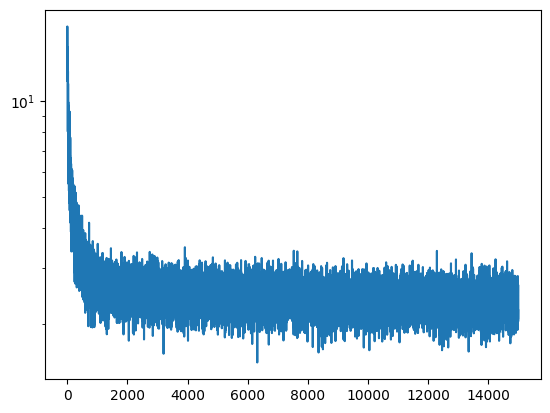

In [5]:
# Plot the loss over time
plt.yscale("log")
plt.plot(loss_over_time)

In [6]:
# Print the final loss over the entire dataset
logits = (C[X].reshape(-1, embedding_size*context_length) @ W1 + b1).tanh() @ W2 + b2
loss = Tensor.sparse_categorical_crossentropy(logits, Y)
print("Final loss:", loss.item())

Final loss: 2.311339855194092


## Inference

In [7]:
# lets do inference

print("Generating 10 random names:")
for i in range(10):
    context = [0] * context_length
    name = ""
    while True:
        # forward pass
        embeddings = C[Tensor(context)]
        h = (embeddings.reshape(-1, embedding_size*context_length) @ W1 + b1).tanh()
        logits = (h @ W2 + b2)
        probs = logits.softmax()
        pred = probs.multinomial(1).item()
        if pred == 0: # the period
            break
        name += itos[pred]
        context = context[1:] + [pred]

    print(name)

Generating 10 random names:
tiriilla
ghaghasyanya
charyallyyaliida
ceimra
yani
nyke
craileye
seree
ykeleas
kadireany
